In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

Nu_of_conflicts =20 # Number of conflicts 10*2=20



In [27]:
class SinkhornNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SinkhornNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.view(-1, 24, 24)
        x = torch.sigmoid(x)  # Apply sigmoid activation to squash values between 0 and 1
        return x

# Adding Noise to the Weights
def add_noise_to_weights(model, noise_factor):
    for param in model.parameters():
        noise = torch.randn_like(param) * noise_factor
        param.data += noise


In [28]:
"""
class SinkhornNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(SinkhornNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = x.view(-1, 24, 24)
        x = torch.sigmoid(x)  # Apply sigmoid activation to squash values between 0 and 1
        return x

# Adding Noise to the Weights
def add_noise_to_weights(model, noise_factor):
    for param in model.parameters():
        noise = torch.randn_like(param) * noise_factor
        param.data += noise

# Example usage
input_size = 784  # For example, if input is a 28x28 image flattened
hidden_size1 = 128
hidden_size2 = 64
hidden_size3 = 32  # New hidden layer size
output_size = 576  # 24x24 output

model = SinkhornNet(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)
"""

'\nclass SinkhornNet(nn.Module):\n    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):\n        super(SinkhornNet, self).__init__()\n        self.fc1 = nn.Linear(input_size, hidden_size1)\n        self.fc2 = nn.Linear(hidden_size1, hidden_size2)\n        self.fc3 = nn.Linear(hidden_size2, hidden_size3)\n        self.fc4 = nn.Linear(hidden_size3, output_size)\n\n    def forward(self, x):\n        x = F.relu(self.fc1(x))\n        x = F.relu(self.fc2(x))\n        x = F.relu(self.fc3(x))\n        x = self.fc4(x)\n        x = x.view(-1, 24, 24)\n        x = torch.sigmoid(x)  # Apply sigmoid activation to squash values between 0 and 1\n        return x\n\n# Adding Noise to the Weights\ndef add_noise_to_weights(model, noise_factor):\n    for param in model.parameters():\n        noise = torch.randn_like(param) * noise_factor\n        param.data += noise\n\n# Example usage\ninput_size = 784  # For example, if input is a 28x28 image flattened\nhidden_size1 

In [29]:

def print_person_seat_assignments(model_output, threshold=0.5):
    """
    Prints the person-seat assignments based on the output tensor from the model.

    Args:
        model_output (torch.Tensor): The output tensor from the model.
        threshold (float, optional): The threshold value for binarizing the output tensor. Default is 0.5.

    Returns:
        None
    """
    # Reshape the output to a 3D tensor
    reshaped_output = model_output.view(1, 24, 24)

    # Apply thresholding to obtain a binary permutation matrix
    binary_perm_matrix = (reshaped_output > threshold).float()
    
    # Initialize the person-seat assignments list
    person_seat_assignments = []

    # Iterate over rows and collect person-seat assignments
    for row_idx, row in enumerate(binary_perm_matrix[0]):
        for seat_idx, value in enumerate(row):
            if value == 1:
                person_seat_assignments.append((row_idx, seat_idx))

    # Print the person-seat assignments
#    for person, seat in person_seat_assignments:
#        print(f"Person {person} - Seat {seat}")

    return person_seat_assignments

In [30]:
""" Custom loss function
function that calculates the loss based on the seating arrangement of 4 rows and 6 columns, 
ensuring that each person has a seat, each seat is assigned to only one person, 
and conflicts with adjacent seats (right, left, top, and bottom) are considered
"""
def custom_loss11(output, pairwise_conflicts, seat_rows=4, seat_cols=6, high_importance=40.0):
    """
    Custom loss function to evaluate the seating arrangement.

    Args:
    - output (torch.Tensor): Output tensor of shape (batch_size, n_persons, n_seats).
                             Each element represents the assignment probability of a person to a seat.
    - pairwise_conflicts (torch.Tensor): Conflict matrix of shape (n_persons, n_persons).
                                         Each element is 1 if the corresponding persons have a conflict, else 0.
    - seat_rows (int): Number of rows in the seating arrangement.
    - seat_cols (int): Number of columns in the seating arrangement.
    - high_importance (float): Factor to give higher importance to person-seat assignment constraints.

    Returns:
    - torch.Tensor: Calculated loss based on seat assignment constraints and conflicts.
    """
    # Get the dimensions of the output
    batch_size, n_persons, n_seats = output.size()
    
    assert n_persons == seat_rows * seat_cols, "Number of persons must be equal to the total number of seats"

    # Ensure each person gets a unique seat (rows should sum to 1)
    row_sum_loss = torch.sum((torch.sum(output, dim=2) - 1) ** 2) * high_importance

    # Ensure each seat is assigned to only one person (columns should sum to 1)
    col_sum_loss = torch.sum((torch.sum(output, dim=1) - 1) ** 2) * high_importance

    # Initialize conflict loss
    conflict_loss = 0

    # Reshape the output to match the seating arrangement dimensions
    output_reshaped = output.view(batch_size, seat_rows, seat_cols, n_persons)

    # Iterate over each seat in the seating arrangement
    for i in range(seat_rows):
        for j in range(seat_cols):
            person_idx = i * seat_cols + j
            person_prob = output_reshaped[:, i, j, :]
            # Check for conflicts with neighboring seats
            if i > 0:  # Up
                neighbor_up_idx = (i - 1) * seat_cols + j
                neighbor_up_prob = output_reshaped[:, i - 1, j, :]
                conflict_loss += torch.sum(person_prob * neighbor_up_prob * pairwise_conflicts[person_idx, neighbor_up_idx])
            if i < seat_rows - 1:  # Down
                neighbor_down_idx = (i + 1) * seat_cols + j
                neighbor_down_prob = output_reshaped[:, i + 1, j, :]
                conflict_loss += torch.sum(person_prob * neighbor_down_prob * pairwise_conflicts[person_idx, neighbor_down_idx])
            if j > 0:  # Left
                neighbor_left_idx = i * seat_cols + (j - 1)
                neighbor_left_prob = output_reshaped[:, i, j - 1, :]
                conflict_loss += torch.sum(person_prob * neighbor_left_prob * pairwise_conflicts[person_idx, neighbor_left_idx])
            if j < seat_cols - 1:  # Right
                neighbor_right_idx = i * seat_cols + (j + 1)
                neighbor_right_prob = output_reshaped[:, i, j + 1, :]
                conflict_loss += torch.sum(person_prob * neighbor_right_prob * pairwise_conflicts[person_idx, neighbor_right_idx])

    # Combine all the losses
    total_loss = row_sum_loss + col_sum_loss + conflict_loss

    return total_loss


In [31]:
""" Custom loss function
function that calculates the loss based on the seating arrangement of 4 rows and 6 columns, 
ensuring that each person has a seat, each seat is assigned to only one person, 
and conflicts with adjacent seats (right, left, top, and bottom) are considered
"""
def custom_loss(output, pairwise_conflicts, seat_rows=4, seat_cols=6, high_importance=20.0):
    """
    Custom loss function to evaluate the seating arrangement.

    Args:
    - output (torch.Tensor): Output tensor of shape (batch_size, n_persons, n_seats).
                             Each element represents the assignment probability of a person to a seat.
    - pairwise_conflicts (torch.Tensor): Conflict matrix of shape (n_persons, n_persons).
                                         Each element is 1 if the corresponding persons have a conflict, else 0.
    - seat_rows (int): Number of rows in the seating arrangement.
    - seat_cols (int): Number of columns in the seating arrangement.
    - high_importance (float): Factor to give higher importance to person-seat assignment constraints.

    Returns:
    - torch.Tensor: Calculated loss based on seat assignment constraints and conflicts.
    """
    # Get the dimensions of the output
    batch_size, n_persons, n_seats = output.size()
    
    assert n_persons == seat_rows * seat_cols, "Number of persons must be equal to the total number of seats"

    # Ensure each person gets a unique seat (rows should sum to 1)
    row_sum_loss = torch.sum((torch.sum(output, dim=2) - 1) ** 2) * high_importance

    # Ensure each seat is assigned to only one person (columns should sum to 1)
    col_sum_loss = torch.sum((torch.sum(output, dim=1) - 1) ** 2) * high_importance

    # Initialize conflict loss
    conflict_loss = 0

    # Reshape the output to match the seating arrangement dimensions
    output_reshaped = output.view(batch_size, seat_rows, seat_cols, n_persons)

    # Iterate over each seat in the seating arrangement
    for i in range(seat_rows):
        for j in range(seat_cols):
            person_idx = i * seat_cols + j
            person_prob = output_reshaped[:, i, j, :]
            # Check for conflicts with neighboring seats
            if i > 0:  # Up
                neighbor_up_idx = (i - 1) * seat_cols + j
                neighbor_up_prob = output_reshaped[:, i - 1, j, :]
                conflict_loss += torch.sum(person_prob * neighbor_up_prob * pairwise_conflicts[person_idx, neighbor_up_idx])
            if i < seat_rows - 1:  # Down
                neighbor_down_idx = (i + 1) * seat_cols + j
                neighbor_down_prob = output_reshaped[:, i + 1, j, :]
                conflict_loss += torch.sum(person_prob * neighbor_down_prob * pairwise_conflicts[person_idx, neighbor_down_idx])
            if j > 0:  # Left
                neighbor_left_idx = i * seat_cols + (j - 1)
                neighbor_left_prob = output_reshaped[:, i, j - 1, :]
                conflict_loss += torch.sum(person_prob * neighbor_left_prob * pairwise_conflicts[person_idx, neighbor_left_idx])
            if j < seat_cols - 1:  # Right
                neighbor_right_idx = i * seat_cols + (j + 1)
                neighbor_right_prob = output_reshaped[:, i, j + 1, :]
                conflict_loss += torch.sum(person_prob * neighbor_right_prob * pairwise_conflicts[person_idx, neighbor_right_idx])

    # Combine all the losses
    total_loss = row_sum_loss + col_sum_loss + conflict_loss

    return total_loss


In [32]:
def print_conflicts(pairwise_conflicts):
    num_persons = pairwise_conflicts.size(0)

    for person in range(num_persons):
        conflicts = []
        for other_person in range(num_persons):
            if pairwise_conflicts[person, other_person] == 1:
                conflicts.append(other_person)

        if conflicts:
            print(f"Person {person} has conflicts with:", ", ".join(f"Person {c}" for c in conflicts))
        else:
            print(f"Person {person} has no conflicts.")

def visualize_conflicts(pairwise_conflicts):
    num_persons = pairwise_conflicts.size(0)
    G = nx.Graph()

    # Add nodes (persons)
    for person in range(num_persons):
        G.add_node(person, label=f"Person {person}")

    # Add edges (conflicts)
    for person1 in range(num_persons):
        for person2 in range(person1 + 1, num_persons):
            if pairwise_conflicts[person1, person2] == 1:
                G.add_edge(person1, person2)

    # Draw the graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', font_size=8, node_size=200)
    plt.axis('equal')
    plt.show()



In [33]:
def visualize_seating_arrangement(person_seat_assignments, pairwise_conflicts, full_names):
    """
    Visualizes the seating arrangement in a 4x6 grid with circles representing persons.
    If two persons with conflicts are sitting next to each other (right, left, top, or down),
    their circles will be red.

    Args:
        person_seat_assignments (list): A list of tuples where each tuple is (person, seat).
        pairwise_conflicts (torch.Tensor): A 24x24 tensor where 0 means no conflict, and 1 means conflict.
        full_names (list): A list containing the full names for each person.
    """
    fig, ax = plt.subplots(4, 6, figsize=(12, 8))
    fig.suptitle('Seating Plan')
    # Clear the axes
    for a in ax.flat:
        a.clear()

    seat_person_map = {seat: person for person, seat in person_seat_assignments}
    #person_seat_map = {person: seat for person, seat in person_seat_assignments}

    ax_array = np.empty((4, 6), dtype=object)

    for i in range(4):
        for j in range(6):
            seat = i * 6 + j
            person = seat_person_map.get(seat)
            color = 'green'
            radius = 0.4  # default radius

            if person is not None:
                # Check for conflicts with adjacent seats
                adjacent_seats = [
                    seat - 1 if j > 0 else None,  # Left
                    seat + 1 if j < 5 else None,  # Right
                    seat - 6 if i > 0 else None,  # Top
                    seat + 6 if i < 3 else None,  # Down
                ]

                for adjacent_seat in adjacent_seats:
                    if adjacent_seat is not None:
                        adjacent_person = seat_person_map.get(adjacent_seat)
                        if adjacent_person is not None:
                            conflict = pairwise_conflicts[person, adjacent_person].item()
                            if conflict == 1:
                                color = 'red'
                                radius= 0.5
                                break

            if person is not None:
                ax[i, j].add_patch(plt.Circle((0.5, 0.5), radius, color=color))
                ax[i, j].text(0.5, 0.55, str(person), ha='center', va='center', fontsize=12)
                ax[i, j].text(0.5, 0.95, full_names[person], ha='center', va='center', fontsize=8)
                ax_array[i, j] = str(person)

            ax[i, j].set_aspect('equal')
            ax[i, j].axis('off')

    plt.show()
    return ax_array


In [34]:
"""
def animate_seating_arrangement(person_seat_assignments, pairwise_conflicts, full_names, fig, ax):
    # Clear the axes
    for a in ax.flat:
        a.clear()

    seat_person_map = {seat: person for person, seat in person_seat_assignments}

    for i in range(4):
        for j in range(6):
            seat = i * 6 + j
            person = seat_person_map.get(seat)
            color = 'green'
            radius = 0.4  # default radius

            if person is not None:
                # Check for conflicts with adjacent seats
                adjacent_seats = [
                    seat - 1 if j > 0 else None,  # Left
                    seat + 1 if j < 5 else None,  # Right
                    seat - 6 if i > 0 else None,  # Top
                    seat + 6 if i < 3 else None,  # Down
                ]

                for adjacent_seat in adjacent_seats:
                    if adjacent_seat is not None:
                        adjacent_person = seat_person_map.get(adjacent_seat)
                        if adjacent_person is not None:
                            conflict = pairwise_conflicts[person, adjacent_person].item()
                            if conflict == 1:
                                color = 'red'
                                radius= 0.5
                                break

            if person is not None:
                ax[i, j].add_patch(plt.Circle((0.5, 0.5), radius, color=color))
                ax[i, j].text(0.5, 0.55, str(person), ha='center', va='center', fontsize=12)
                ax[i, j].text(0.5, 0.95, full_names[person], ha='center', va='center', fontsize=8)

            ax[i, j].set_aspect('equal')
            ax[i, j].axis('off')

    plt.draw()
    plt.pause(0.1)  # Adjust the pause duration as needed
"""

"\ndef animate_seating_arrangement(person_seat_assignments, pairwise_conflicts, full_names, fig, ax):\n    # Clear the axes\n    for a in ax.flat:\n        a.clear()\n\n    seat_person_map = {seat: person for person, seat in person_seat_assignments}\n\n    for i in range(4):\n        for j in range(6):\n            seat = i * 6 + j\n            person = seat_person_map.get(seat)\n            color = 'green'\n            radius = 0.4  # default radius\n\n            if person is not None:\n                # Check for conflicts with adjacent seats\n                adjacent_seats = [\n                    seat - 1 if j > 0 else None,  # Left\n                    seat + 1 if j < 5 else None,  # Right\n                    seat - 6 if i > 0 else None,  # Top\n                    seat + 6 if i < 3 else None,  # Down\n                ]\n\n                for adjacent_seat in adjacent_seats:\n                    if adjacent_seat is not None:\n                        adjacent_person = seat_person

In [35]:
def animate_seating_arrangement(person_seat_assignments, pairwise_conflicts, full_names, fig, ax):
    # Clear the axes
    for a in ax.flat:
        a.clear()

    seat_person_map = {seat: person for person, seat in person_seat_assignments}
    
    green_count = 0
    red_count = 0

    for i in range(4):
        for j in range(6):
            seat = i * 6 + j
            person = seat_person_map.get(seat)
            color = 'green'
            radius = 0.4  # default radius

            if person is not None:
                # Check for conflicts with adjacent seats
                adjacent_seats = [
                    seat - 1 if j > 0 else None,  # Left
                    seat + 1 if j < 5 else None,  # Right
                    seat - 6 if i > 0 else None,  # Top
                    seat + 6 if i < 3 else None,  # Down
                ]

                for adjacent_seat in adjacent_seats:
                    if adjacent_seat is not None:
                        adjacent_person = seat_person_map.get(adjacent_seat)
                        if adjacent_person is not None:
                            conflict = pairwise_conflicts[person, adjacent_person].item()
                            if conflict == 1:
                                color = 'red'
                                radius = 0.5
                                break

                if color == 'green':
                    green_count += 1
                elif color == 'red':
                    red_count += 1

                ax[i, j].add_patch(plt.Circle((0.5, 0.5), radius, color=color))
                ax[i, j].text(0.5, 0.55, str(person), ha='center', va='center', fontsize=12)
                ax[i, j].text(0.5, 0.95, full_names[person], ha='center', va='center', fontsize=8)

            ax[i, j].set_aspect('equal')
            ax[i, j].axis('off')

    fig.suptitle(f'Seating Plan\nGreen seats: {green_count}, Red seats: {red_count}')

    plt.draw()
    plt.pause(0.1)  # Adjust the pause duration as needed
    
    return green_count, red_count


In [36]:
# Generate names for persona_indices

random.seed(42)
torch.manual_seed(42)

first_names = [
    "Ali", "Zahra", "Reza", "Sara", "Mohammad", "Fatemeh",
    "Hossein", "Maryam", "Mehdi", "Narges", "Hamed", "Roya"
]

last_names = [
    "Ahmadi", "Hosseini", "Karimi", "Rahimi", "Hashemi", "Ebrahimi",
    "Moradi", "Mohammadi", "Rostami", "Fazeli", "Hosseinzadeh", "Niknam"
]

full_names = set()
while len(full_names) < 24:
    full_name = random.choice(first_names) + " " + random.choice(last_names)
    full_names.add(full_name)
full_names = list(full_names)

# Print full_names in different rows
for name in full_names:
    print(name)

# Generate persona indices
persona_indices = torch.tensor(range(24), dtype=torch.float32)

Hossein Ebrahimi
Zahra Rahimi
Narges Ahmadi
Reza Niknam
Ali Ahmadi
Mehdi Rahimi
Sara Karimi
Mohammad Ahmadi
Roya Hosseini
Sara Rostami
Hamed Niknam
Sara Ebrahimi
Ali Niknam
Hamed Hosseini
Roya Rostami
Roya Hosseinzadeh
Mohammad Karimi
Narges Moradi
Hossein Rahimi
Zahra Hosseini
Hossein Hosseini
Mohammad Rahimi
Mehdi Hosseini
Maryam Fazeli


Total number of conflicts: tensor(20)
Person 0 has conflicts with: Person 10
Person 1 has conflicts with: Person 7, Person 10
Person 2 has conflicts with: Person 4, Person 8, Person 20, Person 22
Person 3 has no conflicts.
Person 4 has conflicts with: Person 2, Person 10, Person 14
Person 5 has conflicts with: Person 17
Person 6 has conflicts with: Person 16, Person 20
Person 7 has conflicts with: Person 1
Person 8 has conflicts with: Person 2
Person 9 has conflicts with: Person 12
Person 10 has conflicts with: Person 0, Person 1, Person 4, Person 19
Person 11 has no conflicts.
Person 12 has conflicts with: Person 9, Person 20
Person 13 has no conflicts.
Person 14 has conflicts with: Person 4
Person 15 has conflicts with: Person 20
Person 16 has conflicts with: Person 6, Person 22
Person 17 has conflicts with: Person 5, Person 18, Person 22
Person 18 has conflicts with: Person 17, Person 23
Person 19 has conflicts with: Person 10
Person 20 has conflicts with: Person 2, Person 6, Person

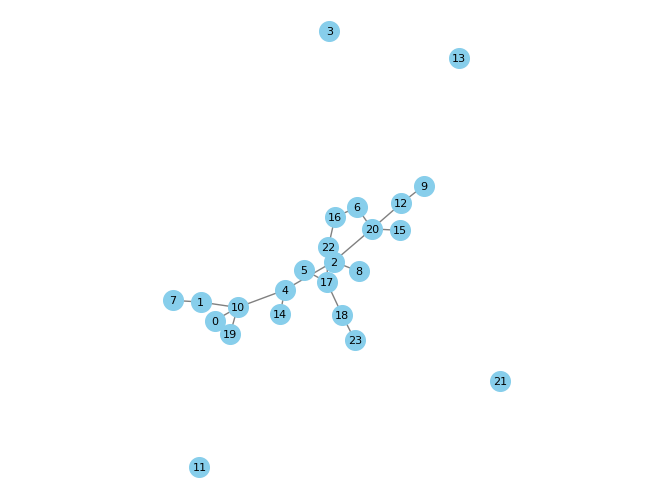

In [37]:
# Convert persona_indices to binary
persona_indices_binary = F.one_hot(persona_indices.long(), num_classes=24).view(1, -1)
persona_indices_binary = persona_indices_binary.type(torch.float64)

# Fix the random seed for generating pairwise_conflicts matrix
torch.manual_seed(20)

# Generate pairwise conflicts matrix
pairwise_conflicts = torch.randint(0, 2, (24, 24))

# Initialize a pairwise conflicts matrix with zeros
pairwise_conflicts = torch.zeros(24, 24, dtype=torch.int)

for _ in range(Nu_of_conflicts):
    i, j = torch.randint(0, 24, (2,))
    while i == j or pairwise_conflicts[i, j] == 1:
        i, j = torch.randint(0, 24, (2,))
    pairwise_conflicts[i, j] = 1
    pairwise_conflicts[j, i] = 1

# Count the total number of conflicts
total_conflicts = pairwise_conflicts.sum() // 2
print("Total number of conflicts:", total_conflicts)
print_conflicts(pairwise_conflicts)

visualize_conflicts(pairwise_conflicts)

In [56]:
# Instantiate the neural network
input_size = 24
hidden_size1 = 800
hidden_size2 = 400
output_size = 24 * 24
model = SinkhornNet(input_size, hidden_size1,hidden_size2 , output_size)

"""
input_size = 24 
hidden_size1 = 300
hidden_size2 = 200
hidden_size3 = 100 
output_size = 576  # 24x24 output
model = SinkhornNet(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)
"""


# Initialize the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [57]:
# Training loop

%matplotlib qt
from IPython.display import display, clear_output

LOSS=0.0001

num_epochs = 500
train_input = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], dtype=torch.float32)

seating_arrangements = []

# Create a new figure and axes
fig, ax = plt.subplots(4, 6, figsize=(12, 8))
#fig.suptitle('Seating Plan')

New_input = train_input

for epoch in range(num_epochs):
    optimizer.zero_grad()
    perm_matrix = model(New_input)
    loss = custom_loss(perm_matrix, pairwise_conflicts)
    loss.backward()
    optimizer.step()

    # Add noise to the weights every 500 epochs
    if (epoch + 1) % 500 == 0:
        add_noise_to_weights(model, noise_factor=0.01)

    if (epoch + 1) % 20 == 0:
        # visualize every 100 epoch
        final_perm_matrix = model(train_input)

        # Thresholding
        threshold = 0.5
        perm_matrix_flat = (final_perm_matrix > threshold).float().flatten()
        
        # Find indices where perm_matrix_flat is 1
        indices = perm_matrix_flat.nonzero().squeeze()
        
        # Convert indices to numbers between 0 and 23
        positions = indices % 24
        
        # Create New_input tensor with all numbers from 0 to 23
        New_input = torch.arange(24, dtype=torch.float32)
        
        # Determine missing numbers not generated in output
        missing_numbers = list(set(range(24)) - set(positions.tolist()))
        random.shuffle(missing_numbers)
        
        # Replace positions with actual output values and missing positions with random missing numbers
        for i in range(24):
            if i < len(positions):
                New_input[i] = positions[i]
            else:
                New_input[i] = missing_numbers.pop()
        
        #print(New_input)

        
        
        seat_arrangement = print_person_seat_assignments(final_perm_matrix)
        #animate_seating_arrangement(seat_arrangement, pairwise_conflicts, full_names, fig, ax)
        green_count, red_count = animate_seating_arrangement(seat_arrangement, pairwise_conflicts, full_names, fig, ax)
        if green_count ==24:
            print(f'All seats are correctly assinged, Loss = ', loss.item())
            break

    # Stop training by reaching to desirable loss
    if loss.item() <= LOSS:
        print(f'Loss reached below {LOSS} Breaking the loop: ', loss.item())
        break
   
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], total_loss: {loss.item()}')
        for txt in fig.texts:
            if txt.get_text().startswith('Epoch'):
                txt.remove()
        fig.text(0.1, 0.05, f'Epoch [{epoch+1}/{num_epochs}], total_loss: {loss.item()}', fontsize=10, ha='left')


# Keep the window open until it's closed manually
plt.show()   


Epoch [20/500], total_loss: 519.9667358398438
Epoch [40/500], total_loss: 159.08775329589844
Epoch [60/500], total_loss: 18.51502227783203
Epoch [80/500], total_loss: 0.7643818855285645
All seats are correctly assinged, Loss =  0.00031827017664909363


In [54]:
# Add noise to the weights if needed
add_noise_to_weights(model, noise_factor=0.05)

# Lowering learning rate if needed
for param_group in optimizer.param_groups:
    param_group['lr'] = 0.0001  # Set the learning rate to a new value (e.g., 0.0001)


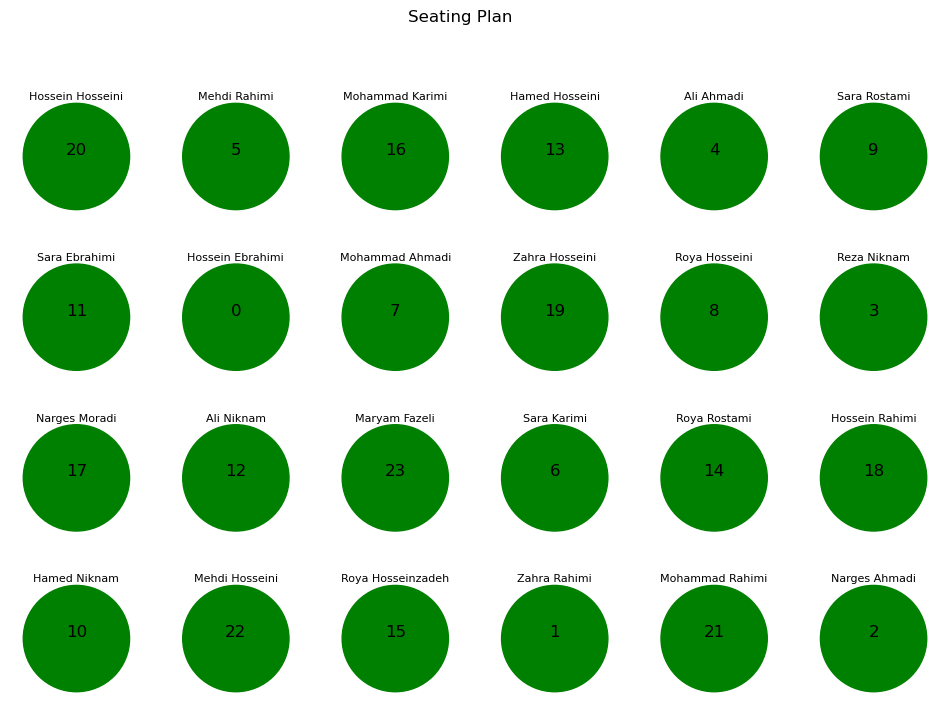

In [59]:
# Final output
%matplotlib inline
from IPython.display import display


final_perm_matrix = model(train_input)
seat_arrangement = print_person_seat_assignments(final_perm_matrix)
# usage:
best_seating=visualize_seating_arrangement(seat_arrangement, pairwise_conflicts, full_names)


In [63]:
seat_arrangement

[(0, 7),
 (1, 21),
 (2, 23),
 (3, 11),
 (4, 4),
 (5, 1),
 (6, 15),
 (7, 8),
 (8, 10),
 (9, 5),
 (10, 18),
 (11, 6),
 (12, 13),
 (13, 3),
 (14, 16),
 (15, 20),
 (16, 2),
 (17, 12),
 (18, 17),
 (19, 9),
 (20, 0),
 (21, 22),
 (22, 19),
 (23, 14)]

In [65]:
# Sort seat_arrangement based on the second column (names/umbers)
sorted_seat_arrangement = sorted(seat_arrangement, key=lambda x: x[1])

sorted_seat_arrangement


[(20, 0),
 (5, 1),
 (16, 2),
 (13, 3),
 (4, 4),
 (9, 5),
 (11, 6),
 (0, 7),
 (7, 8),
 (19, 9),
 (8, 10),
 (3, 11),
 (17, 12),
 (12, 13),
 (23, 14),
 (6, 15),
 (14, 16),
 (18, 17),
 (10, 18),
 (22, 19),
 (15, 20),
 (1, 21),
 (21, 22),
 (2, 23)]